# Anderson Impurity Model ground state solver on Infleqtion's Sqale

Ground state quantum chemistry—computing total energies of molecular configurations to within chemical accuracy—is perhaps the most highly-touted industrial application of fault-tolerant quantum computers. Strongly correlated materials, for example, are particularly interesting, and tools like dynamical mean-field theory (DMFT) allow one to account for the effect of their strong, localized electronic correlations. These DMFT models help predict material properties by approximating the system as a single site impurity inside a “bath” that encompasses the rest of the system. Simulating such dynamics can be a tough task using classical methods, but can be done efficiently on a quantum computer via quantum simulation.

In this notebook, we showcase a workflow for preparing the ground state of the minimal single-impurity Anderson model (SIAM) using the Hamiltonian Variational Ansatz for a range of realistic parameters. As a first step towards running DMFT on a fault-tolerant quantum computer, we will use logical qubits encoded in the `[[4, 2, 2]]` code. Using this workflow, we will obtain the ground state energy estimates via noisy simulation, and then also execute the corresponding optimized circuits on Infleqtion's gate-based neutral-atom quantum computer, making the benefits of logical qubits apparent. More details can be found in our [paper](https://arxiv.org/abs/2412.07670).

This demo notebook uses CUDA-Q (`cudaq`) and a CUDA-QX library, `cudaq-solvers`; let us first begin by importing (and installing as needed) these packages:

In [1]:
try:
    import cudaq_solvers as solvers
    import cudaq
    import matplotlib.pyplot as plt
except ImportError:
    print("Installing required packages...")
    %pip install --quiet 'cudaq-solvers' 'matplotlib'
    print("Installed `cudaq`, `cudaq-solvers`, and `matplotlib` packages.")
    print("You may need to restart the kernel to import newly installed packages.")
    import cudaq_solvers as solvers
    import cudaq
    import matplotlib.pyplot as plt

from collections.abc import Mapping, Sequence
import numpy as np
from scipy.optimize import minimize
import os

## Performing logical Variational Quantum Eigensolver (VQE) with CUDA-QX

To prepare our ground state quantum Anderson impurity model circuits (referred to as AIM circuits in this notebook for short), we use VQE to train an ansatz to minimize a Hamiltonian and obtain optimal angles that can be used to set the AIM circuits. As described in our [paper](https://arxiv.org/abs/2412.07670), the associated restricted Hamiltonian for our SIAM can be reduced to,
$$  
\begin{equation}
H_{(U, V)} = U (Z_0 Z_2 - 1) / 4 + V (X_0 + X_2),
\end{equation}
$$
where $U$ is the Coulomb interaction and $V$ the hybridization strength. In this notebook workflow, we will optimize over a 2-dimensional grid of Hamiltonian parameter values, namely $U\in \{1, 5, 9\}$ and $V\in \{-9, -1, 7\}$ (with all values assumed to be in units of eV), to ensure that the ansatz is generally trainable and expressive, and obtain 9 different circuit layers identified by the key $(U, V)$. We will simulate the VQE on GPU (or optionally on CPU if you do not have GPU access), enabled by CUDA-Q, in the absence of noise:

In [2]:
if cudaq.num_available_gpus() == 0:
    cudaq.set_target("qpp-cpu", option="fp64")
else:
    cudaq.set_target("nvidia", option="fp64")

This workflow can be easily defined in CUDA-Q as shown in the cell below, using the CUDA-QX Solvers library (which accelerates quantum algorithms like the VQE):

In [3]:
def ansatz(n_qubits: int) -> cudaq.Kernel:
    # Create a CUDA-Q parameterized kernel
    paramterized_ansatz, variational_angles = cudaq.make_kernel(list)
    qubits = paramterized_ansatz.qalloc(n_qubits)

    # Using |+> as the initial state:
    paramterized_ansatz.h(qubits[0])
    paramterized_ansatz.cx(qubits[0], qubits[1])

    paramterized_ansatz.rx(variational_angles[0], qubits[0])
    paramterized_ansatz.cx(qubits[0], qubits[1])
    paramterized_ansatz.rz(variational_angles[1], qubits[1])
    paramterized_ansatz.cx(qubits[0], qubits[1])
    return paramterized_ansatz


def run_logical_vqe(cudaq_hamiltonian: cudaq.SpinOperator) -> tuple[float, list[float]]:
    # Set seed for easier reproduction
    np.random.seed(42)

    # Initial angles for the optimizer
    init_angles = np.random.random(2) * 1e-1

    # Obtain CUDA-Q Ansatz
    num_qubits = cudaq_hamiltonian.get_qubit_count()
    variational_kernel = ansatz(num_qubits)

    # Perform VQE optimization
    energy, params, _ = solvers.vqe(
        variational_kernel,
        cudaq_hamiltonian,
        init_angles,
        optimizer=minimize,
        method="SLSQP",
        tol=1e-10,
    )
    return energy, params

## Constructing circuits in the `[[4,2,2]]` encoding

The `[[4,2,2]]` code is a quantum error detection code that uses four physical qubits to encode two logical qubits. In this notebook, we will construct two variants of quantum circuits: physical (bare, unencoded) and logical (encoded). These circuits will be informed by the Hamiltonian Variational Ansatz described earlier. To measure all the terms in our Hamiltonian, we will measure the data qubits in both the $Z$- and $X$-basis, as allowed by the `[[4,2,2]]` logical gateset. Full details on the circuit constructions are outlined in our [paper](https://arxiv.org/abs/2412.07670).

Below, we create functions to build our CUDA-Q AIM circuits, both physical and logical versions. As we consider noisy simulation in this notebook, we will include some noisy gates. Here, for simplicity, we will just register a custom identity gate -- to be later used as a noisy operation to model readout error: 

In [4]:
cudaq.register_operation("meas_id", np.identity(2))

In [5]:
def aim_physical_circuit(
    angles: list[float], basis: str, *, ignore_meas_id: bool = False
) -> cudaq.Kernel:
    kernel = cudaq.make_kernel()
    qubits = kernel.qalloc(2)

    # Bell state prep
    kernel.h(qubits[0])
    kernel.cx(qubits[0], qubits[1])

    # Rx Gate
    kernel.rx(angles[0], qubits[0])

    # ZZ rotation
    kernel.cx(qubits[0], qubits[1])
    kernel.rz(angles[1], qubits[1])
    kernel.cx(qubits[0], qubits[1])

    if basis == "z_basis":
        if not ignore_meas_id:
            kernel.for_loop(
                start=0, stop=2, function=lambda q_idx: getattr(kernel, "meas_id")(qubits[q_idx])
            )
        kernel.mz(qubits)
    elif basis == "x_basis":
        kernel.h(qubits)
        if not ignore_meas_id:
            kernel.for_loop(
                start=0, stop=2, function=lambda q_idx: getattr(kernel, "meas_id")(qubits[q_idx])
            )
        kernel.mz(qubits)
    else:
        raise ValueError("Unsupported basis provided:", basis)
    return kernel

In [6]:
def aim_logical_circuit(
    angles: list[float], basis: str, *, ignore_meas_id: bool = False
) -> cudaq.Kernel:
    kernel = cudaq.make_kernel()
    qubits = kernel.qalloc(6)

    kernel.for_loop(start=0, stop=3, function=lambda idx: kernel.h(qubits[idx]))
    kernel.cx(qubits[1], qubits[4])
    kernel.cx(qubits[2], qubits[3])
    kernel.cx(qubits[0], qubits[1])
    kernel.cx(qubits[0], qubits[3])

    # Rx teleportation
    kernel.rx(angles[0], qubits[0])

    kernel.cx(qubits[0], qubits[1])
    kernel.cx(qubits[0], qubits[3])
    kernel.h(qubits[0])

    if basis == "z_basis":
        if not ignore_meas_id:
            kernel.for_loop(
                start=0, stop=5, function=lambda idx: getattr(kernel, "meas_id")(qubits[idx])
            )
        kernel.mz(qubits)
    elif basis == "x_basis":
        # ZZ rotation and teleportation
        kernel.cx(qubits[3], qubits[5])
        kernel.cx(qubits[2], qubits[5])
        kernel.rz(angles[1], qubits[5])
        kernel.cx(qubits[1], qubits[5])
        kernel.cx(qubits[4], qubits[5])
        kernel.for_loop(start=1, stop=5, function=lambda idx: kernel.h(qubits[idx]))
        if not ignore_meas_id:
            kernel.for_loop(
                start=0, stop=6, function=lambda idx: getattr(kernel, "meas_id")(qubits[idx])
            )
        kernel.mz(qubits)
    else:
        raise ValueError("Unsupported basis provided:", basis)
    return kernel

With the circuit definitions above, we can now define a function that automatically runs the VQE and constructs a dictionary containing all the AIM circuits we want to submit to hardware (or noisily simulate):

In [7]:
def generate_circuit_set(ignore_meas_id: bool = False) -> object:
    u_vals = [1, 5, 9]
    v_vals = [-9, -1, 7]
    circuit_dict = {}
    for u in u_vals:
        for v in v_vals:
            qubit_hamiltonian = (
                0.25 * u * cudaq.spin.z(0) * cudaq.spin.z(1)
                - 0.25 * u
                + v * cudaq.spin.x(0)
                + v * cudaq.spin.x(1)
            )
            _, opt_params = run_logical_vqe(qubit_hamiltonian)
            angles = [float(angle) for angle in opt_params]
            print(f"Computed optimal angles={angles} for U={u}, V={v}")

            tmp_physical_dict = {}
            tmp_logical_dict = {}
            for basis in ("z_basis", "x_basis"):
                tmp_physical_dict[basis] = aim_physical_circuit(
                    angles, basis, ignore_meas_id=ignore_meas_id
                )
                tmp_logical_dict[basis] = aim_logical_circuit(
                    angles, basis, ignore_meas_id=ignore_meas_id
                )

            circuit_dict[f"{u}:{v}"] = {
                "physical": tmp_physical_dict,
                "logical": tmp_logical_dict,
            }
    print("\nFinished building optimized circuits!")
    return circuit_dict

In [8]:
sim_circuit_dict = generate_circuit_set()
circuit_layers = sim_circuit_dict.keys()

Computed optimal angles=[1.5846845738799267, 1.5707961678256028] for U=1, V=-9
Computed optimal angles=[4.588033710930825, 4.712388365176642] for U=1, V=-1
Computed optimal angles=[-1.588651490745171, 1.5707962742876598] for U=1, V=7
Computed optimal angles=[1.64012940802256, 1.5707963354922125] for U=5, V=-9
Computed optimal angles=[2.1293956916868737, 1.5707963294715355] for U=5, V=-1
Computed optimal angles=[-1.6598458659836037, 1.570796331040382] for U=5, V=7
Computed optimal angles=[1.695151467539617, 1.5707960973500679] for U=9, V=-9
Computed optimal angles=[2.4149519241823376, 1.5707928509325972] for U=9, V=-1
Computed optimal angles=[-1.7301462729177735, 1.570796033796985] for U=9, V=7

Finished building optimized circuits!


## Setting up submission and decoding workflow 

In this section, we define various helper functions that will play a role in generating the associated energies of the AIM circuits based on the circuit samples (in the different bases), as well as decode the logical circuits with post-selection informed by the `[[4,2,2]]` code:

In [9]:
def _num_qubits(counts: Mapping[str, float]) -> int:
    for key in counts:
        if key.isdecimal():
            return len(key)
    return 0


def process_counts(
    counts: Mapping[str, float],
    data_qubits: Sequence[int],
    flag_qubits: Sequence[int] = (),
) -> dict[str, float]:
    new_data: dict[str, float] = {}
    for key, val in counts.items():
        if not all(key[i] == "0" for i in flag_qubits):
            continue

        new_key = "".join(key[i] for i in data_qubits)

        if not set("01").issuperset(new_key):
            continue

        new_data.setdefault(new_key, 0)
        new_data[new_key] += val

    return new_data


def decode(counts: Mapping[str, float]) -> dict[str, float]:
    """Decode physical counts into logical counts. Should be called after `process_counts`."""

    if not counts:
        return {}

    num_qubits = _num_qubits(counts)
    assert num_qubits % 4 == 0

    physical_to_logical = {
        "0000": "00",
        "1111": "00",
        "0011": "01",
        "1100": "01",
        "0101": "10",
        "1010": "10",
        "0110": "11",
        "1001": "11",
    }

    new_data: dict[str, float] = {}
    for key, val in counts.items():
        physical_keys = [key[i : i + 4] for i in range(0, num_qubits, 4)]
        logical_keys = [physical_to_logical.get(physical_key) for physical_key in physical_keys]
        if None not in logical_keys:
            new_key = "".join(logical_keys)
            new_data.setdefault(new_key, 0)
            new_data[new_key] += val

    return new_data


def ev_x(counts: Mapping[str, float]) -> float:
    ev = 0.0

    for k, val in counts.items():
        ev += val * ((-1) ** int(k[0]) + (-1) ** int(k[1]))

    total = sum(counts.values())
    ev /= total
    return ev


def ev_xx(counts: Mapping[str, float]) -> float:
    ev = 0.0

    for k, val in counts.items():
        ev += val * (-1) ** k.count("1")

    total = sum(counts.values())
    ev /= total
    return ev


def ev_zz(counts: Mapping[str, float]) -> float:
    ev = 0.0

    for k, val in counts.items():
        ev += val * (-1) ** k.count("1")

    total = sum(counts.values())
    ev /= total
    return ev


def aim_logical_energies(
    data_ordering: object, counts_list: Sequence[dict[str, float]]
) -> tuple[dict[tuple[int, int], float], dict[tuple[int, int], float]]:
    counts_data = {
        data_ordering[i]: decode(
            process_counts(
                counts,
                data_qubits=[1, 2, 3, 4],
                flag_qubits=[0, 5],
            )
        )
        for i, counts in enumerate(counts_list)
    }
    return _aim_energies(counts_data)


def aim_physical_energies(
    data_ordering: object, counts_list: Sequence[dict[str, float]]
) -> tuple[dict[tuple[int, int], float], dict[tuple[int, int], float]]:
    counts_data = {
        data_ordering[i]: process_counts(
            counts,
            data_qubits=[0, 1],
        )
        for i, counts in enumerate(counts_list)
    }
    return _aim_energies(counts_data)


def _aim_energies(
    counts_data: Mapping[tuple[int, int, str], dict[str, float]],
) -> tuple[dict[tuple[int, int], float], dict[tuple[int, int], float]]:
    evxs: dict[tuple[int, int], float] = {}
    evxxs: dict[tuple[int, int], float] = {}
    evzzs: dict[tuple[int, int], float] = {}
    totals: dict[tuple[int, int], float] = {}

    for key, counts in counts_data.items():
        h_params, basis = key
        key_a, key_b = h_params.split(":")
        u, v = int(key_a), int(key_b)
        if basis.startswith("x"):
            evxs[u, v] = ev_x(counts)
            evxxs[u, v] = ev_xx(counts)
        else:
            evzzs[u, v] = ev_zz(counts)

        totals.setdefault((u, v), 0)
        totals[u, v] += sum(counts.values())

    energies = {}
    uncertainties = {}
    for u, v in evxs.keys() & evzzs.keys():
        string_key = f"{u}:{v}"
        energies[string_key] = u * (evzzs[u, v] - 1) / 4 + v * evxs[u, v]

        uncertainty_xx = 2 * v**2 * (1 + evxxs[u, v]) - u * v * evxs[u, v] / 2
        uncertainty_zz = u**2 * (1 - evzzs[u, v]) / 2

        uncertainties[string_key] = np.sqrt(
            (uncertainty_zz + uncertainty_xx - energies[string_key] ** 2) / (totals[u, v] / 2)
        )

    return energies, uncertainties


def _get_energy_diff(
    bf_energies: dict[str, float],
    physical_energies: dict[str, float],
    logical_energies: dict[str, float],
) -> tuple[list[float], list[float]]:
    physical_energy_diff = []
    logical_energy_diff = []

    # Data ordering following `bf_energies` keys
    for layer in bf_energies.keys():
        physical_sim_energy = physical_energies[layer]
        logical_sim_energy = logical_energies[layer]
        true_energy = bf_energies[layer]
        u, v = layer.split(":")
        print(f"Layer=({u}, {v}) has brute-force energy of: {true_energy}")
        print(f"Physical circuit of layer=({u}, {v}) got an energy of: {physical_sim_energy}")
        print(f"Logical circuit of layer=({u}, {v}) got an energy of: {logical_sim_energy}")
        print("-" * 72)

        if logical_sim_energy < physical_sim_energy:
            print("Logical circuit achieved the lower energy!")
        else:
            print("Physical circuit achieved the lower energy")
        print("-" * 72, "\n")

        physical_energy_diff.append(
            -1 * (true_energy - physical_sim_energy)
        )  # Multiply by -1 since negative energies
        logical_energy_diff.append(-1 * (true_energy - logical_sim_energy))
    return physical_energy_diff, logical_energy_diff

In [10]:
def submit_aim_circuits(
    circuit_dict: object,
    *,
    folder_path: str = "future_aim_results",
    shots_count: int = 1000,
    noise_model: cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.NoiseModel | None = None,
    run_async: bool = False,
) -> dict[str, list[dict[str, int]]] | None:
    if run_async:
        os.makedirs(folder_path, exist_ok=True)
    else:
        aim_results = {"physical": [], "logical": []}

    for layer in circuit_dict.keys():
        if run_async:
            print(f"Posting circuits associated with layer=('{layer}')")
        else:
            print(f"Running circuits associated with layer=('{layer}')")

        for basis in ("z_basis", "x_basis"):
            if run_async:
                u, v = layer.split(":")

                tmp_physical_results = cudaq.sample_async(
                    circuit_dict[layer]["physical"][basis], shots_count=shots_count
                )
                file = open(f"{folder_path}/physical_{basis}_job_u={u}_v={v}_result.txt", "w")
                file.write(str(tmp_physical_results))
                file.close()

                tmp_logical_results = cudaq.sample_async(
                    circuit_dict[layer]["logical"][basis], shots_count=shots_count
                )
                file = open(f"{folder_path}/logical_{basis}_job_u={u}_v={v}_result.txt", "w")
                file.write(str(tmp_logical_results))
                file.close()
            else:
                tmp_physical_results = cudaq.sample(
                    circuit_dict[layer]["physical"][basis],
                    shots_count=shots_count,
                    noise_model=noise_model,
                )
                tmp_logical_results = cudaq.sample(
                    circuit_dict[layer]["logical"][basis],
                    shots_count=shots_count,
                    noise_model=noise_model,
                )
                aim_results["physical"].append({k: v for k, v in tmp_physical_results.items()})
                aim_results["logical"].append({k: v for k, v in tmp_logical_results.items()})
    if not run_async:
        print("\nCompleted all circuit sampling!")
        return aim_results
    else:
        print("\nAll circuits submitted for async sampling!")

In [11]:
def _get_async_results(
    layers: object, *, folder_path: str = "future_aim_results"
) -> dict[str, list[dict[str, int]]]:
    aim_results = {"physical": [], "logical": []}
    for layer in layers:
        print(f"Retrieving all circuits counts associated with layer=('{layer}')")
        u, v = layer.split(":")
        for basis in ("z_basis", "x_basis"):
            file = open(f"{folder_path}/physical_{basis}_job_u={u}_v={v}_result.txt", "r")
            tmp_physical_results = cudaq.AsyncSampleResult(str(file.read()))
            physical_counts = tmp_physical_results.get()

            file = open(f"{folder_path}/logical_{basis}_job_u={u}_v={v}_result.txt", "r")
            tmp_logical_results = cudaq.AsyncSampleResult(str(file.read()))
            logical_counts = tmp_logical_results.get()

            aim_results["physical"].append({k: v for k, v in physical_counts.items()})
            aim_results["logical"].append({k: v for k, v in logical_counts.items()})

    print("\nObtained all circuit samples!")
    return aim_results

## Running a CUDA-Q noisy simulation

In this section, we will first explore the performance of the physical and logical circuits under the influence of a device noise model. This will help us predict experimental results, as well as understand the dominant error sources at play. Such a simulation can be achieved via CUDA-Q's density matrix simulator: 

In [12]:
cudaq.reset_target()
cudaq.set_target("density-matrix-cpu")

In [13]:
def get_device_noise(
    depolar_prob_1q: float,
    depolar_prob_2q: float,
    *,
    readout_error_prob: float | None = None,
    custom_gates: list[str] | None = None,
) -> cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.NoiseModel:
    noise = cudaq.NoiseModel()
    depolar_noise = cudaq.DepolarizationChannel(depolar_prob_1q)

    noisy_ops = ["z", "s", "x", "h", "rx", "rz"]
    for op in noisy_ops:
        noise.add_all_qubit_channel(op, depolar_noise)

    if custom_gates:
        custom_depolar_channel = cudaq.DepolarizationChannel(depolar_prob_1q)
        for op in custom_gates:
            noise.add_all_qubit_channel(op, custom_depolar_channel)

    # Two qubit depolarization error
    p_0 = 1 - depolar_prob_2q
    p_1 = np.sqrt((1 - p_0**2) / 3)

    k0 = np.array(
        [[p_0, 0.0, 0.0, 0.0], [0.0, p_0, 0.0, 0.0], [0.0, 0.0, p_0, 0.0], [0.0, 0.0, 0.0, p_0]],
        dtype=np.complex128,
    )
    k1 = np.array(
        [[0.0, 0.0, p_1, 0.0], [0.0, 0.0, 0.0, p_1], [p_1, 0.0, 0.0, 0.0], [0.0, p_1, 0.0, 0.0]],
        dtype=np.complex128,
    )
    k2 = np.array(
        [
            [0.0, 0.0, -1j * p_1, 0.0],
            [0.0, 0.0, 0.0, -1j * p_1],
            [1j * p_1, 0.0, 0.0, 0.0],
            [0.0, 1j * p_1, 0.0, 0.0],
        ],
        dtype=np.complex128,
    )
    k3 = np.array(
        [[p_1, 0.0, 0.0, 0.0], [0.0, p_1, 0.0, 0.0], [0.0, 0.0, -p_1, 0.0], [0.0, 0.0, 0.0, -p_1]],
        dtype=np.complex128,
    )
    kraus_channel = cudaq.KrausChannel([k0, k1, k2, k3])

    noise.add_all_qubit_channel("cz", kraus_channel)
    noise.add_all_qubit_channel("cx", kraus_channel)

    if readout_error_prob is not None:
        # Readout error modeled with a Bit flip channel on identity before measurement
        bit_flip = cudaq.BitFlipChannel(readout_error_prob)
        noise.add_all_qubit_channel("meas_id", bit_flip)
    return noise

Finally, with our example noise model defined above, we can synchronously & noisily sample all of our AIM circuits by passing `noise_model=cudaq_noise_model` to the workflow containing function `submit_aim_circuits()`:

In [14]:
# Example parameters that can model execution on hardware at the high, simulation, level:
# Take single-qubit gate depolarization rate: ~0.2% or better (fidelity ≥99.8%)
# Take two-qubit gate depolarization rate: ~1–2% (fidelity ~98–99%)
cudaq_noise_model = get_device_noise(0.002, 0.02, readout_error_prob=0.02)

In [15]:
aim_sim_data = submit_aim_circuits(sim_circuit_dict, noise_model=cudaq_noise_model)

Running circuits associated with layer=('1:-9')
Running circuits associated with layer=('1:-1')
Running circuits associated with layer=('1:7')
Running circuits associated with layer=('5:-9')
Running circuits associated with layer=('5:-1')
Running circuits associated with layer=('5:7')
Running circuits associated with layer=('9:-9')
Running circuits associated with layer=('9:-1')
Running circuits associated with layer=('9:7')

Completed all circuit sampling!


In [16]:
data_ordering = []
for key in circuit_layers:
    for basis in ("z_basis", "x_basis"):
        data_ordering.append((key, basis))

In [17]:
sim_physical_energies, sim_physical_uncertainties = aim_physical_energies(
    data_ordering, aim_sim_data["physical"]
)

In [18]:
sim_logical_energies, sim_logical_uncertainties = aim_logical_energies(
    data_ordering, aim_sim_data["logical"]
)

To analyze our simulated energy results in the above cells, we will compare them to the brute-force computed exact ground state energies for the AIM Hamiltonian. For simplicity, these are already stored in the dictionary `bf_energies` below:

In [19]:
bf_energies = {
    "1:-9": -18.251736027394713,
    "1:-1": -2.265564437074638,
    "1:7": -14.252231964940428,
    "5:-9": -19.293350575766127,
    "5:-1": -3.608495283014149,
    "5:7": -15.305692796870582,
    "9:-9": -20.39007993367173,
    "9:-1": -5.260398644698076,
    "9:7": -16.429650912487233,
}

With the above metric, we can assess the performance of the logical circuits against the physical circuits by considering how far away the respective energies are from the brute-force expected energies. The cell below computes these energy deviations:

In [20]:
sim_physical_energy_diff, sim_logical_energy_diff = _get_energy_diff(
    bf_energies, sim_physical_energies, sim_logical_energies
)

Layer=(1, -9) has brute-force energy of: -18.251736027394713
Physical circuit of layer=(1, -9) got an energy of: -15.929
Logical circuit of layer=(1, -9) got an energy of: -17.46016175277361
------------------------------------------------------------------------
Logical circuit achieved the lower energy!
------------------------------------------------------------------------ 

Layer=(1, -1) has brute-force energy of: -2.265564437074638
Physical circuit of layer=(1, -1) got an energy of: -1.97
Logical circuit of layer=(1, -1) got an energy of: -2.176531948420889
------------------------------------------------------------------------
Logical circuit achieved the lower energy!
------------------------------------------------------------------------ 

Layer=(1, 7) has brute-force energy of: -14.252231964940428
Physical circuit of layer=(1, 7) got an energy of: -12.268
Logical circuit of layer=(1, 7) got an energy of: -13.26321740664324
---------------------------------------------------

Both physical and logical circuits were subject to the same noise model, but the `[[4,2,2]]` provides additional information that can help overcome some errors. Visualizing the computed energy differences from the above the cell, our noisy simulation provides a preview of the benefits logical qubits can offer:

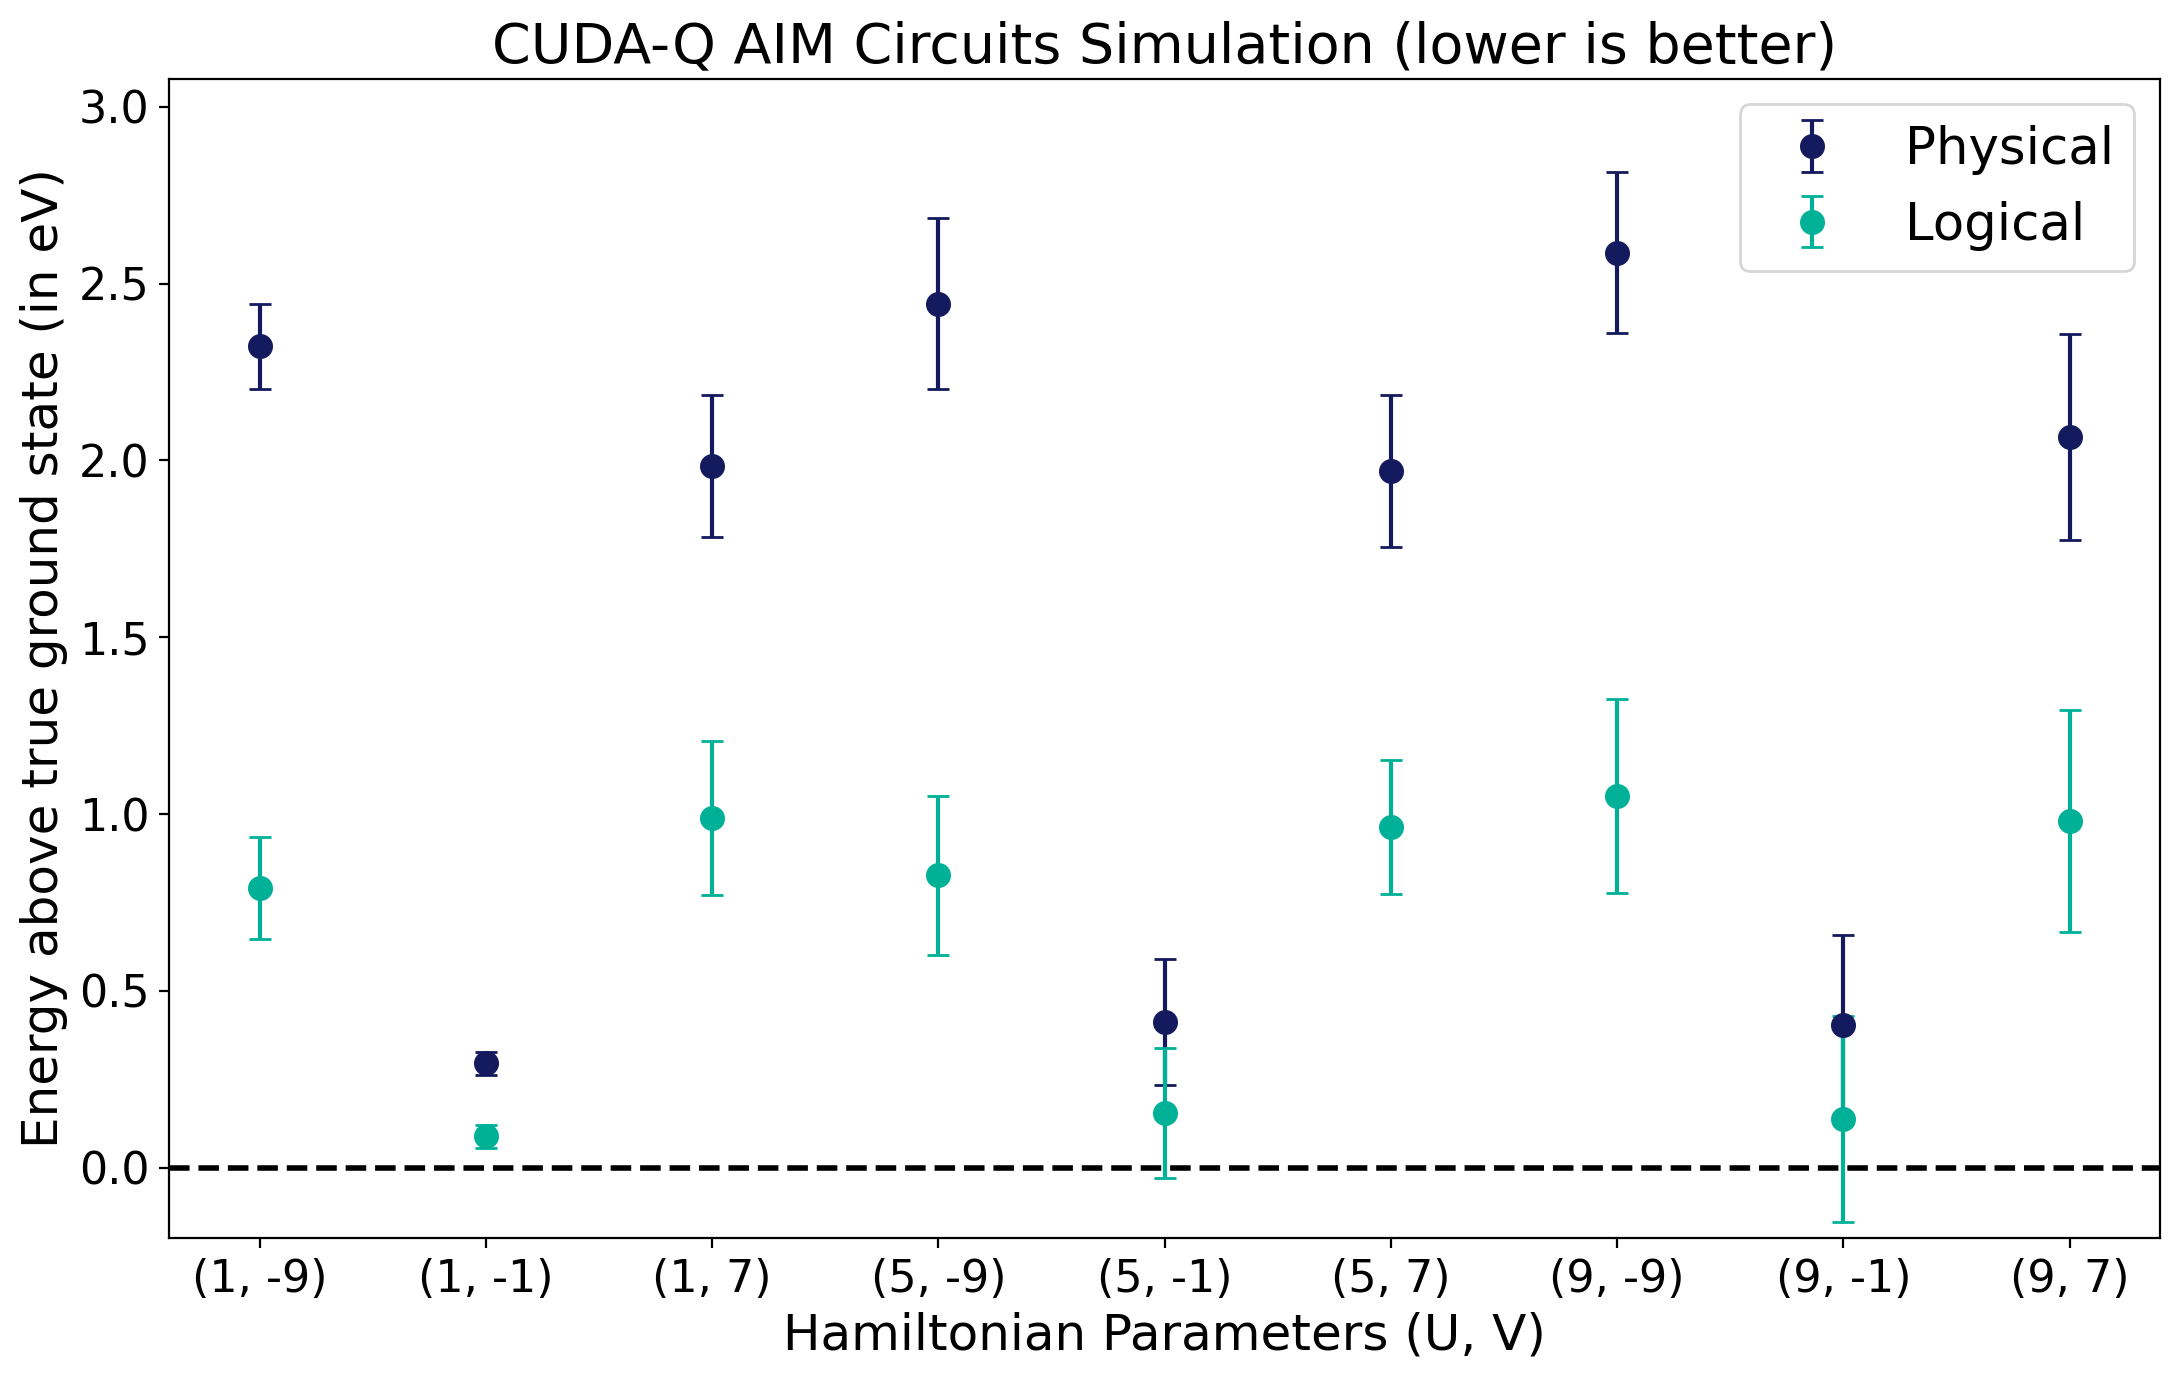

In [21]:
fig, ax = plt.subplots(figsize=(11, 7), dpi=200)

layer_labels = [(int(key.split(":")[0]), int(key.split(":")[1])) for key in bf_energies.keys()]
plot_labels = [str(item) for item in layer_labels]

plt.errorbar(
    plot_labels,
    sim_physical_energy_diff,
    yerr=sim_physical_uncertainties.values(),
    ecolor=(20 / 255.0, 26 / 255.0, 94 / 255.0),
    color=(20 / 255.0, 26 / 255.0, 94 / 255.0),
    capsize=4,
    elinewidth=1.5,
    fmt="o",
    markersize=8,
    markeredgewidth=1,
    label="Physical",
)

plt.errorbar(
    plot_labels,
    sim_logical_energy_diff,
    yerr=sim_logical_uncertainties.values(),
    color=(0, 177 / 255.0, 152 / 255.0),
    ecolor=(0, 177 / 255.0, 152 / 255.0),
    capsize=4,
    elinewidth=1.5,
    fmt="o",
    markersize=8,
    markeredgewidth=1,
    label="Logical",
)

ax.set_xlabel("Hamiltonian Parameters (U, V)", fontsize=18)
ax.set_ylabel("Energy above true ground state (in eV)", fontsize=18)
ax.set_title("CUDA-Q AIM Circuits Simulation (lower is better)", fontsize=20)
ax.legend(loc="upper right", fontsize=18.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.axhline(y=0, color="black", linestyle="--", linewidth=2)
plt.ylim(
    top=max(sim_physical_energy_diff) + max(sim_physical_uncertainties.values()) + 0.2, bottom=-0.2
)
plt.tight_layout()
plt.show()

## Running logical AIM on Infleqtion's hardware 

The entire workflow we've seen thus far can be seamlessly executed on real quantum hardware as well. CUDA-Q has integration with Infleqtion's gate-based neutral atom quantum computer, [Sqale](https://arxiv.org/html/2408.08288v2), allowing execution of CUDA-Q kernels on neutral-atom hardware via Infleqtion’s cross-platform Superstaq compiler API that performs low-level compilation and optimization under the hood. Indeed, the AIM research results seen in [our paper](https://arxiv.org/abs/2412.07670) were obtained via this complete end-to-end workflow.

To do so, users can obtain a Superstaq API key from [superstaq.infleqtion.com](https://superstaq.infleqtion.com/) to gain access to Infleqtion's neutral-atom simulator, with [pre-registration](https://www.infleqtion.com/sqale-preregistration) open for access to Infleqtion’s neutral atom QPU.

As a tutorial, let us reproduce the workflow we've run so far but on Infleqtion's QPU. We begin with the same GPU-enhanced VQE to generate the AIM circuits:

In [22]:
cudaq.reset_target()

if cudaq.num_available_gpus() == 0:
    cudaq.set_target("qpp-cpu", option="fp64")
else:
    cudaq.set_target("nvidia", option="fp64")

In [23]:
device_circuit_dict = generate_circuit_set(
    ignore_meas_id=True
)  # Setting `ignore_meas_id=True` drops the noisy-identity gate from earlier

Computed optimal angles=[1.5846845738799267, 1.5707961678256028] for U=1, V=-9
Computed optimal angles=[4.588033710930825, 4.712388365176642] for U=1, V=-1
Computed optimal angles=[-1.588651490745171, 1.5707962742876598] for U=1, V=7
Computed optimal angles=[1.64012940802256, 1.5707963354922125] for U=5, V=-9
Computed optimal angles=[2.1293956916868737, 1.5707963294715355] for U=5, V=-1
Computed optimal angles=[-1.6598458659836037, 1.570796331040382] for U=5, V=7
Computed optimal angles=[1.695151467539617, 1.5707960973500679] for U=9, V=-9
Computed optimal angles=[2.4149519241823376, 1.5707928509325972] for U=9, V=-1
Computed optimal angles=[-1.7301462945564499, 1.570796044872433] for U=9, V=7

Finished building optimized circuits!


And now, we change backends! Before selecting an Infleqtion machine in CUDA-Q, we must first set our Superstaq API key, like so:

In [24]:
# os.environ['SUPERSTAQ_API_KEY'] = "api_key"

Next, we declare the type of execution we would like on Infleqtion's machine based on the keyword options specified:

In [25]:
cudaq.reset_target()

# Set the following to run on Infleqtion's Sqale QPU:
cudaq.set_target("infleqtion", machine="cq_sqale_qpu")

# Set the following to run an ideal dry-run on Infleqtion's Sqale QPU:
# cudaq.set_target("infleqtion", machine="cq_sqale_qpu", method="dry-run")

# Set the following to run a device-realistic noisy simulation of Infleqtion's Sqale QPU:
# cudaq.set_target("infleqtion", machine="cq_sqale_qpu", method="noise-sim")

# Set the following to run a local, ideal emulation:
# cudaq.set_target("infleqtion", emulate=True)

With that, we're all set! That simple change instructs our AIM circuits to execute on Infleqtion's QPU (or simulator). Due to the general queue wait time of running on hardware, we optionally recommend enabling the `run_async=True` flag to asynchronously sample the circuits. This will allow the cell to be executed and not wait synchronously until all the jobs are complete, allowing other classical code to be run in the meantime. When using `run_async`, an optional directory to store the job information can be specified with `folder_path` (this will be important to later retrieve the job results from the same directory)

In [26]:
submit_aim_circuits(
    device_circuit_dict, folder_path="hardware_aim_future_results", shots_count=1000, run_async=True
)

Posting circuits associated with layer=('1:-9')
Posting circuits associated with layer=('1:-1')
Posting circuits associated with layer=('1:7')
Posting circuits associated with layer=('5:-9')
Posting circuits associated with layer=('5:-1')
Posting circuits associated with layer=('5:7')
Posting circuits associated with layer=('9:-9')
Posting circuits associated with layer=('9:-1')
Posting circuits associated with layer=('9:7')

All circuits submitted for async sampling!


With the above cell execution, all the circuits will post to execute on QPU. We can then return at a later time to retrieve the job results with the cell below:

In [27]:
aim_device_data = _get_async_results(circuit_layers, folder_path="hardware_aim_future_results")

Retrieving all circuits counts associated with layer=('1:-9')
Retrieving all circuits counts associated with layer=('1:-1')
Retrieving all circuits counts associated with layer=('1:7')
Retrieving all circuits counts associated with layer=('5:-9')
Retrieving all circuits counts associated with layer=('5:-1')
Retrieving all circuits counts associated with layer=('5:7')
Retrieving all circuits counts associated with layer=('9:-9')
Retrieving all circuits counts associated with layer=('9:-1')
Retrieving all circuits counts associated with layer=('9:7')

Obtained all circuit samples!


In [28]:
physical_energies, physical_uncertainties = aim_physical_energies(
    data_ordering, aim_device_data["physical"]
)

In [29]:
logical_energies, logical_uncertainties = aim_logical_energies(
    data_ordering, aim_device_data["logical"]
)

In [30]:
physical_energy_diff, logical_energy_diff = _get_energy_diff(
    bf_energies, physical_energies, logical_energies
)

Layer=(1, -9) has brute-force energy of: -18.251736027394713
Physical circuit of layer=(1, -9) got an energy of: -17.626499999999997
Logical circuit of layer=(1, -9) got an energy of: -17.69666562801761
------------------------------------------------------------------------
Logical circuit achieved the lower energy!
------------------------------------------------------------------------ 

Layer=(1, -1) has brute-force energy of: -2.265564437074638
Physical circuit of layer=(1, -1) got an energy of: -2.1415
Logical circuit of layer=(1, -1) got an energy of: -2.2032104443266585
------------------------------------------------------------------------
Logical circuit achieved the lower energy!
------------------------------------------------------------------------ 

Layer=(1, 7) has brute-force energy of: -14.252231964940428
Physical circuit of layer=(1, 7) got an energy of: -12.9955
Logical circuit of layer=(1, 7) got an energy of: -13.76919450035401
-----------------------------------

As before, we use the same metric of comparing against the true ground state energies; however, this time, both the physical and logical circuits are fully exposed to real hardware noise. Yet, we expect the use of logical qubits afforded to us by the `[[4,2,2]]` code to achieve energies closer to the true ground state than the bare physical circuits (up to a certain error threshold). And indeed they do! Visually, we can plot the energy deviations of both the physical and logical circuits from the cell above and observe that the logical circuits are able to outperform the physical circuits by obtaining much lower energies, demonstrating the power of error detection and the beginning possibilities of fault-tolerant quantum computation: 

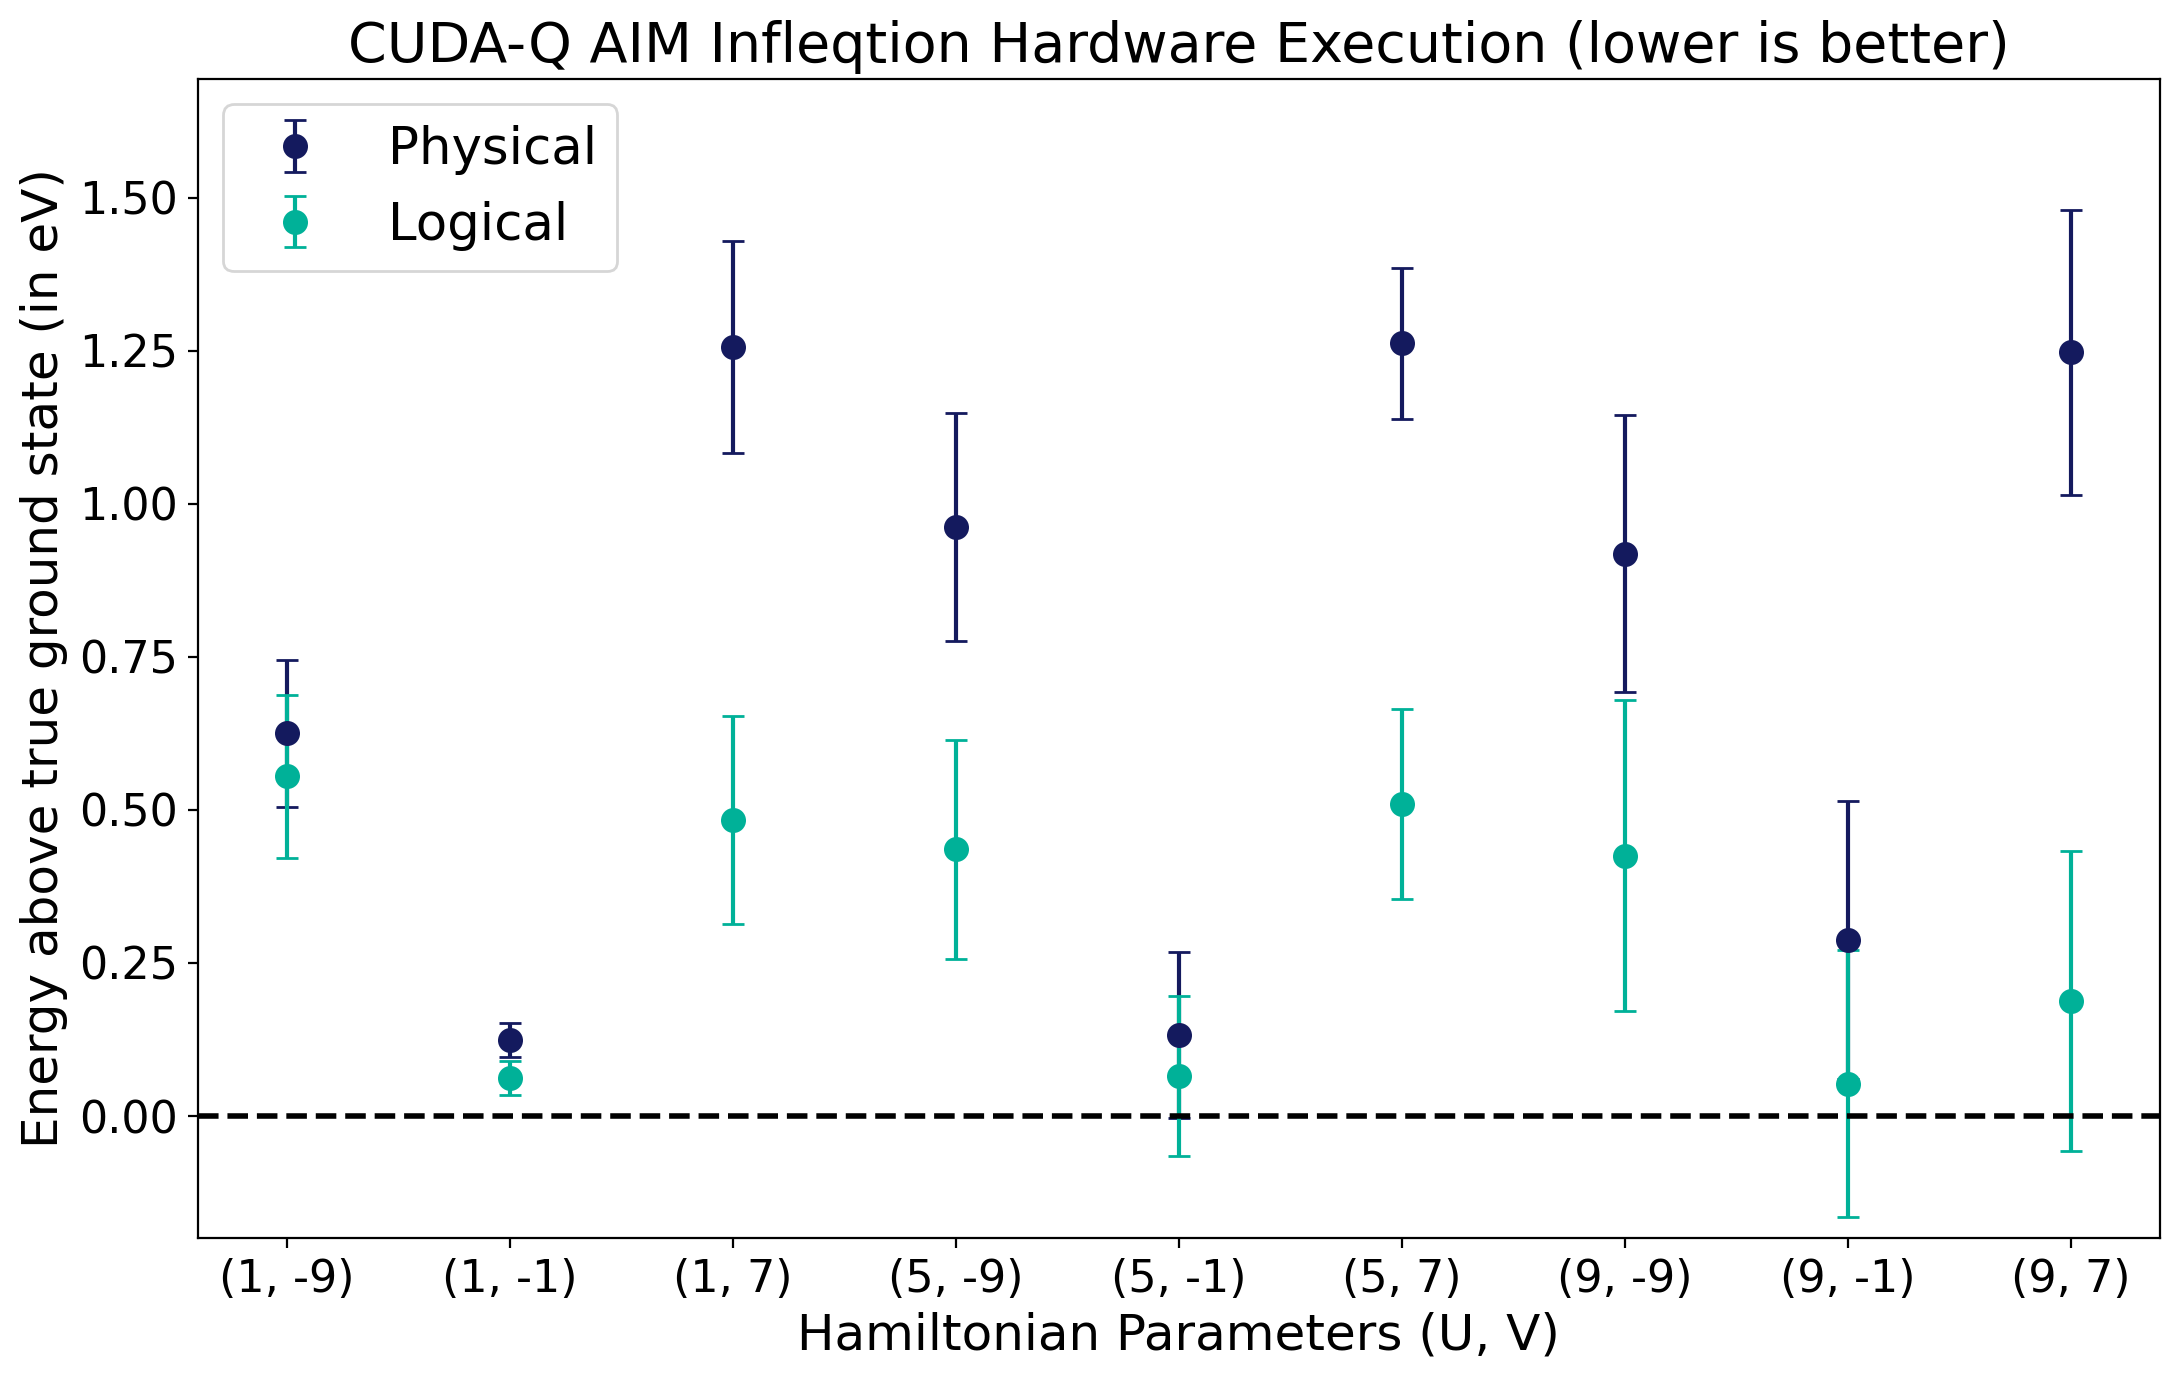

In [31]:
fig, ax = plt.subplots(figsize=(11, 7), dpi=200)

plt.errorbar(
    plot_labels,
    physical_energy_diff,
    yerr=physical_uncertainties.values(),
    ecolor=(20 / 255.0, 26 / 255.0, 94 / 255.0),
    color=(20 / 255.0, 26 / 255.0, 94 / 255.0),
    capsize=4,
    elinewidth=1.5,
    fmt="o",
    markersize=8,
    markeredgewidth=1,
    label="Physical",
)
plt.errorbar(
    plot_labels,
    logical_energy_diff,
    yerr=logical_uncertainties.values(),
    color=(0, 177 / 255.0, 152 / 255.0),
    ecolor=(0, 177 / 255.0, 152 / 255.0),
    capsize=4,
    elinewidth=1.5,
    fmt="o",
    markersize=8,
    markeredgewidth=1,
    label="Logical",
)

ax.set_xlabel("Hamiltonian Parameters (U, V)", fontsize=18)
ax.set_ylabel("Energy above true ground state (in eV)", fontsize=18)
ax.set_title("CUDA-Q AIM Infleqtion Hardware Execution (lower is better)", fontsize=20)
ax.legend(loc="upper left", fontsize=18.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.axhline(y=0, color="black", linestyle="--", linewidth=2)
plt.ylim(top=max(physical_energy_diff) + max(physical_uncertainties.values()) + 0.2, bottom=-0.2)
plt.tight_layout()
plt.show()